In [1]:
%pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/tensorflow/examples.git to c:\users\asus\appdata\local\temp\pip-req-build-bd6n0ais
  Resolved https://github.com/tensorflow/examples.git to commit 39023864834a05965ed6e72c195140dc413f4b02
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1738929081.325461987918117995536210174468518373090689764098-py3-none-any.whl size=303879 sha256=8226cf89a1fd316217dd8a944f56b98d9634d044d679ebb2bbaa7c9b71fa0faf
  Stored in directory: C:\Users\ASUS\AppData\Local\Temp\pip-ephem-wheel-cache-nedtxh2a\wheels\ab\17\30\d16d07e2c95286770a9ddcd6f41629ea92b998858c5ee235aa
Successfully built tensorflow-examples
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git 'C:\Users\ASUS\AppData\Local\Temp\pip-req-build-bd6n0ais'


In [3]:
%pip install tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   - -------------------------------------- 0.3/5.3 MB ? eta -:--:--
   - -------------------------------------- 0.3/5.3 MB ? eta -:--:--
   - -------------------------------------- 0.3/5.3 MB ? eta -:--:

In [ ]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt
ds, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

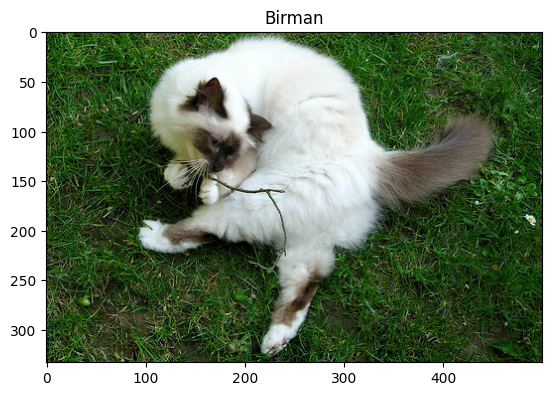

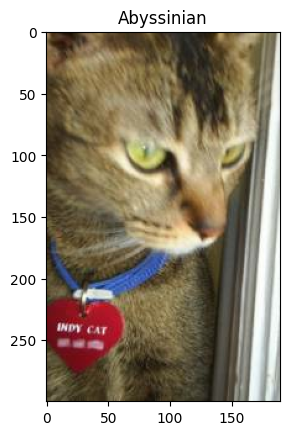

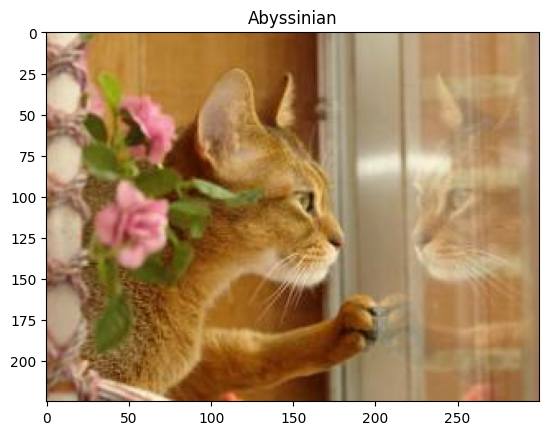

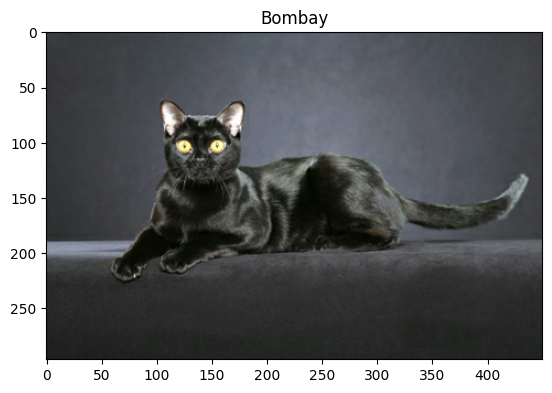

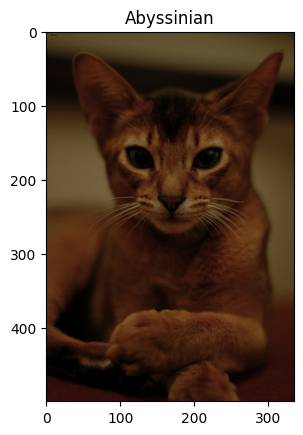

In [15]:
for i in range(5):
    random_index = np.random.randint(0, len(df))
    img = tf.io.read_file(df['Image_Path'][random_index])
    img = tf.image.decode_jpeg(img, channels=3)
    plt.imshow(img)
    plt.title(df['Label'][random_index])
    plt.show()

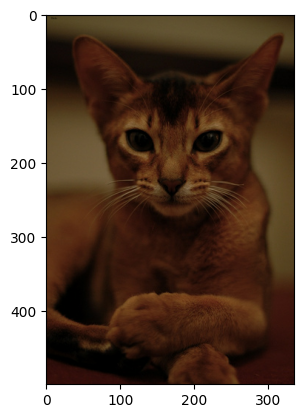

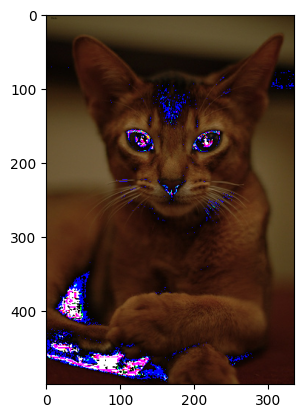

In [19]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask
input_image , input_mask = normalize(img, img)
plt.imshow(input_image)
plt.show()
plt.imshow(input_mask)
plt.show()

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
#    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[0]))
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]),alpha=0.5)
    plt.axis('off')
  plt.show()

for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
show_predictions(test_batches)

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

    
EPOCHS = 3
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
show_predictions(test_batches, 3)